In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
class VectorQuantizerEMA(torch.nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = torch.nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = torch.nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = torch.nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = torch.nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = torch.nn.functional.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, n_input_channels, hidden_size, latent_dim):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(n_input_channels, hidden_size, kernel_size=3, stride=2, padding=1),
        torch.nn.GELU(),
        torch.nn.Conv2d(hidden_size, hidden_size, kernel_size=3),
        torch.nn.GELU(),
        torch.nn.Conv2d(hidden_size, 2*hidden_size, kernel_size=3),
        torch.nn.GELU(),
        torch.nn.Conv2d(2*hidden_size, 2*hidden_size, kernel_size=3, stride=2),
        torch.nn.GELU(),
        #torch.nn.Flatten()
    )

    #self.linear_mean = torch.nn.Linear(2*hidden_size*25, latent_dim)
    #self.linear_logvar = torch.nn.Linear(2*hidden_size*25, latent_dim)
    #self.linear = torch.nn.Linear(2*hidden_size*16, latent_dim)

  def forward(self, x):
    x = self.model(x)
    #x = self.linear(x)
    return x

In [ ]:
class Decoder(torch.nn.Module):
  def __init__(self, n_input_channels, hidden_size, latent_dim):
    super().__init__()
    #self.linear = torch.nn.Sequential(torch.nn.Linear(latent_dim, 2 * 16 * hidden_size), torch.nn.GELU())

    self.model = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(2*hidden_size, 2*hidden_size, kernel_size=3, stride=2, padding=1, output_padding=1), 
        torch.nn.GELU(),
        torch.nn.Conv2d(2*hidden_size, 2*hidden_size, kernel_size=3, padding=1),
        torch.nn.GELU(),
        torch.nn.ConvTranspose2d(2*hidden_size, hidden_size, kernel_size=3, stride=2, output_padding=1, padding=1), 
        torch.nn.GELU(),
        torch.nn.Conv2d(hidden_size, hidden_size, kernel_size=3), # , padding=1
        torch.nn.GELU(),
        torch.nn.ConvTranspose2d(hidden_size, n_input_channels, kernel_size=3, stride=2, output_padding=1, padding=1), 
        torch.nn.Tanh(),
        #torch.nn.Sigmoid(),
    )

  def forward(self, x):
    #x = self.linear(x)
    #x = x.reshape(x.shape[0], -1, 4, 4)
    x = self.model(x)
    return x

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self, n_input_channels, hidden_size, latent_dim, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
    super().__init__()

    self.encoder = Encoder(n_input_channels, hidden_size, latent_dim)
    self.decoder = Decoder(n_input_channels, hidden_size, latent_dim)
    self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5)

  def forward(self, x):
    x = self.encoder(x)
    loss, quantized, perplexity, enc = self._vq_vae(x)
    x = self.decoder(quantized)
    return x, enc, loss, perplexity

In [ ]:
def visualize_grid(x_batch):
  im_rec = Image.fromarray(torchvision.utils.make_grid((x_batch*0.5+0.5) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
  #im_rec = Image.fromarray(torchvision.utils.make_grid((x_batch) * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
  return im_rec.resize((im_rec.size[0]*4, im_rec.size[1]*4))

In [ ]:
n_input_channels, hidden_size, latent_dim = 1, 28, 16
num_embeddings, embedding_dim, commitment_cost = 128, 56, 0.25 # embedding_dim = num_channels at the output of the encoder
batch_size = 128
learning_rate = 1e-3
decay = 0.99
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Autoencoder(n_input_channels, hidden_size, latent_dim, num_embeddings, embedding_dim, commitment_cost, decay).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data_variance = torch.var(trainset.data / 255.0)

In [ ]:
for epoch in range(7):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        x, labels = data
        x = x.to(device)
        optimizer.zero_grad()
        #x, enc, loss, perplexity
        x_hat, enc, vq_loss, perplexity = model(x)
        mse_loss = torch.nn.functional.mse_loss(x, x_hat) / data_variance
        #mse_loss = mse_loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        #bce_loss = torch.nn.functional.binary_cross_entropy(x_hat.view(-1, 1024), x.view(-1, 1024), reduction='sum')
        #loss = bce_loss + kl_loss 
        loss = mse_loss + vq_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % batch_size * 5 == batch_size * 5 - 5:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (batch_size * 5):.3f}')
            running_loss = 0.0

    if (epoch + 1) % 3 == 0:
      for g in optimizer.param_groups:
        learning_rate *= 0.1
        g['lr'] = learning_rate

[1,   128] loss: 0.221
[1,   256] loss: 0.222
[1,   384] loss: 0.222
[2,   128] loss: 0.221
[2,   256] loss: 0.221
[2,   384] loss: 0.220
[3,   128] loss: 0.220
[3,   256] loss: 0.220
[3,   384] loss: 0.220
[4,   128] loss: 0.221
[4,   256] loss: 0.219
[4,   384] loss: 0.218
[5,   128] loss: 0.220
[5,   256] loss: 0.219
[5,   384] loss: 0.217
[6,   128] loss: 0.217
[6,   256] loss: 0.218
[6,   384] loss: 0.219
[7,   128] loss: 0.218
[7,   256] loss: 0.218
[7,   384] loss: 0.217


In [ ]:
for data in testloader:
  x, labels = data
  x = x.to(device)

  with torch.no_grad():
    x_hat = model(x)[0]

  break

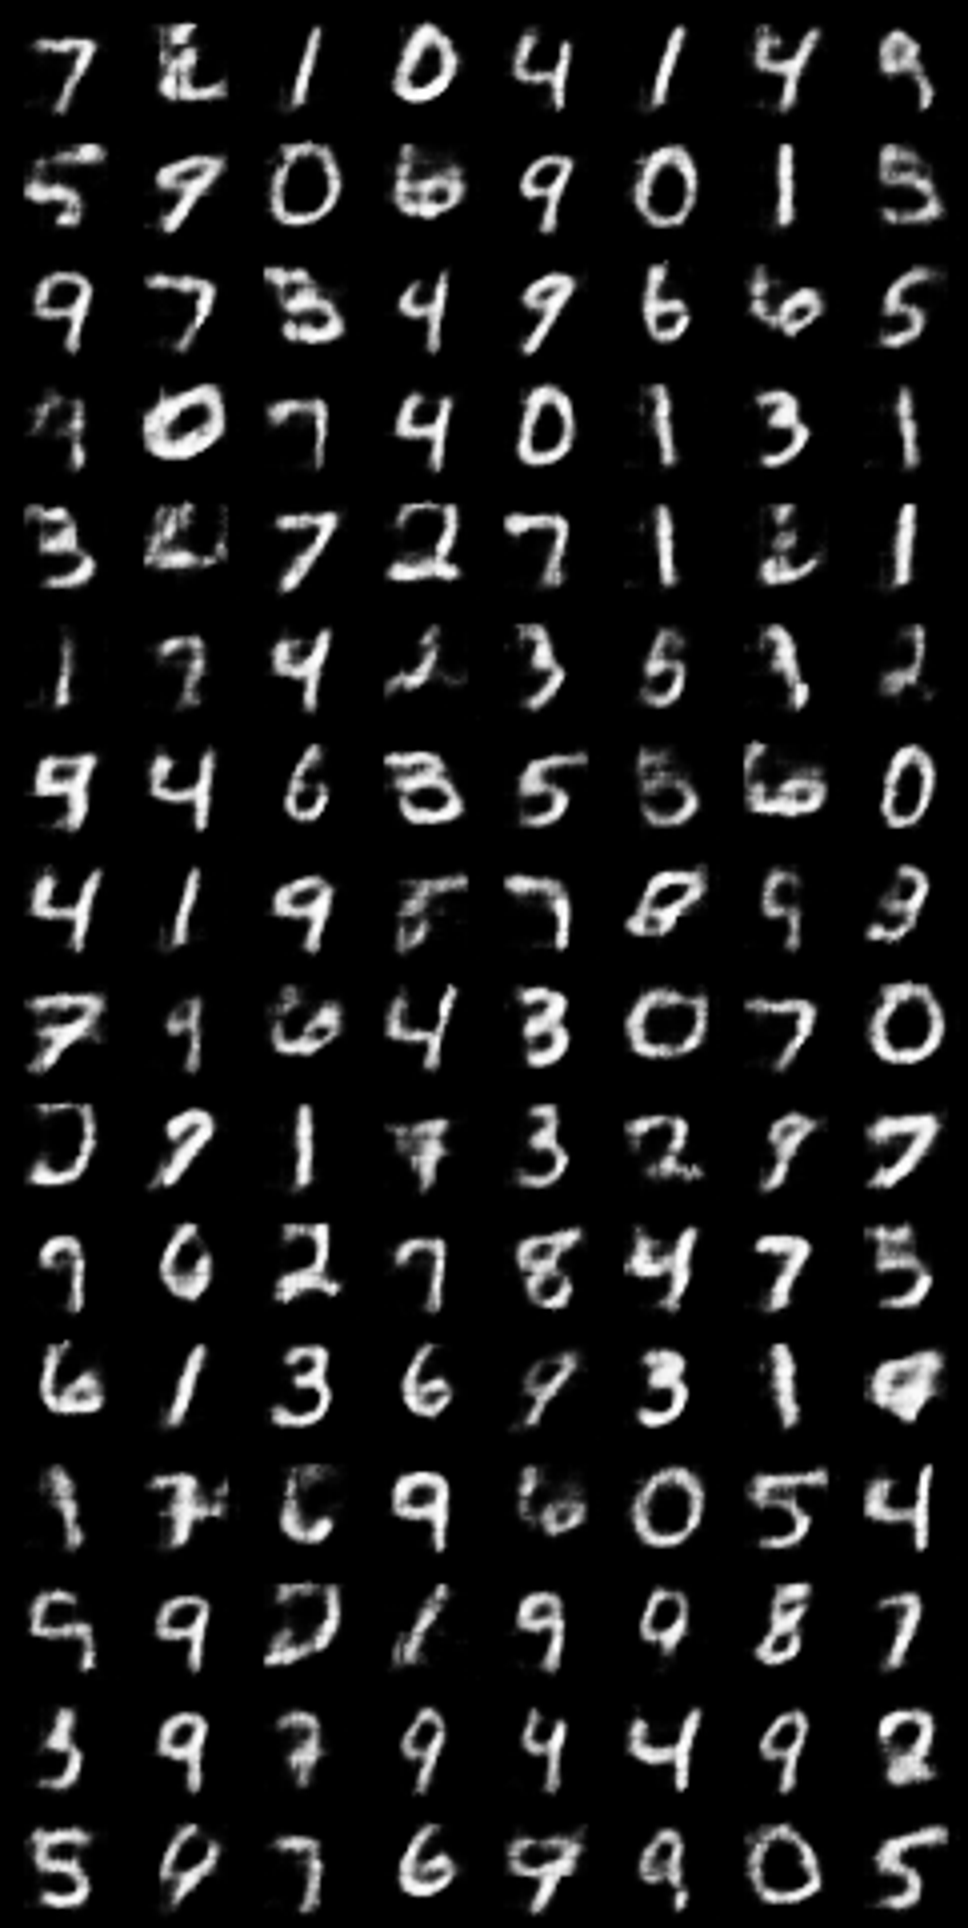

In [ ]:
visualize_grid(x_hat)

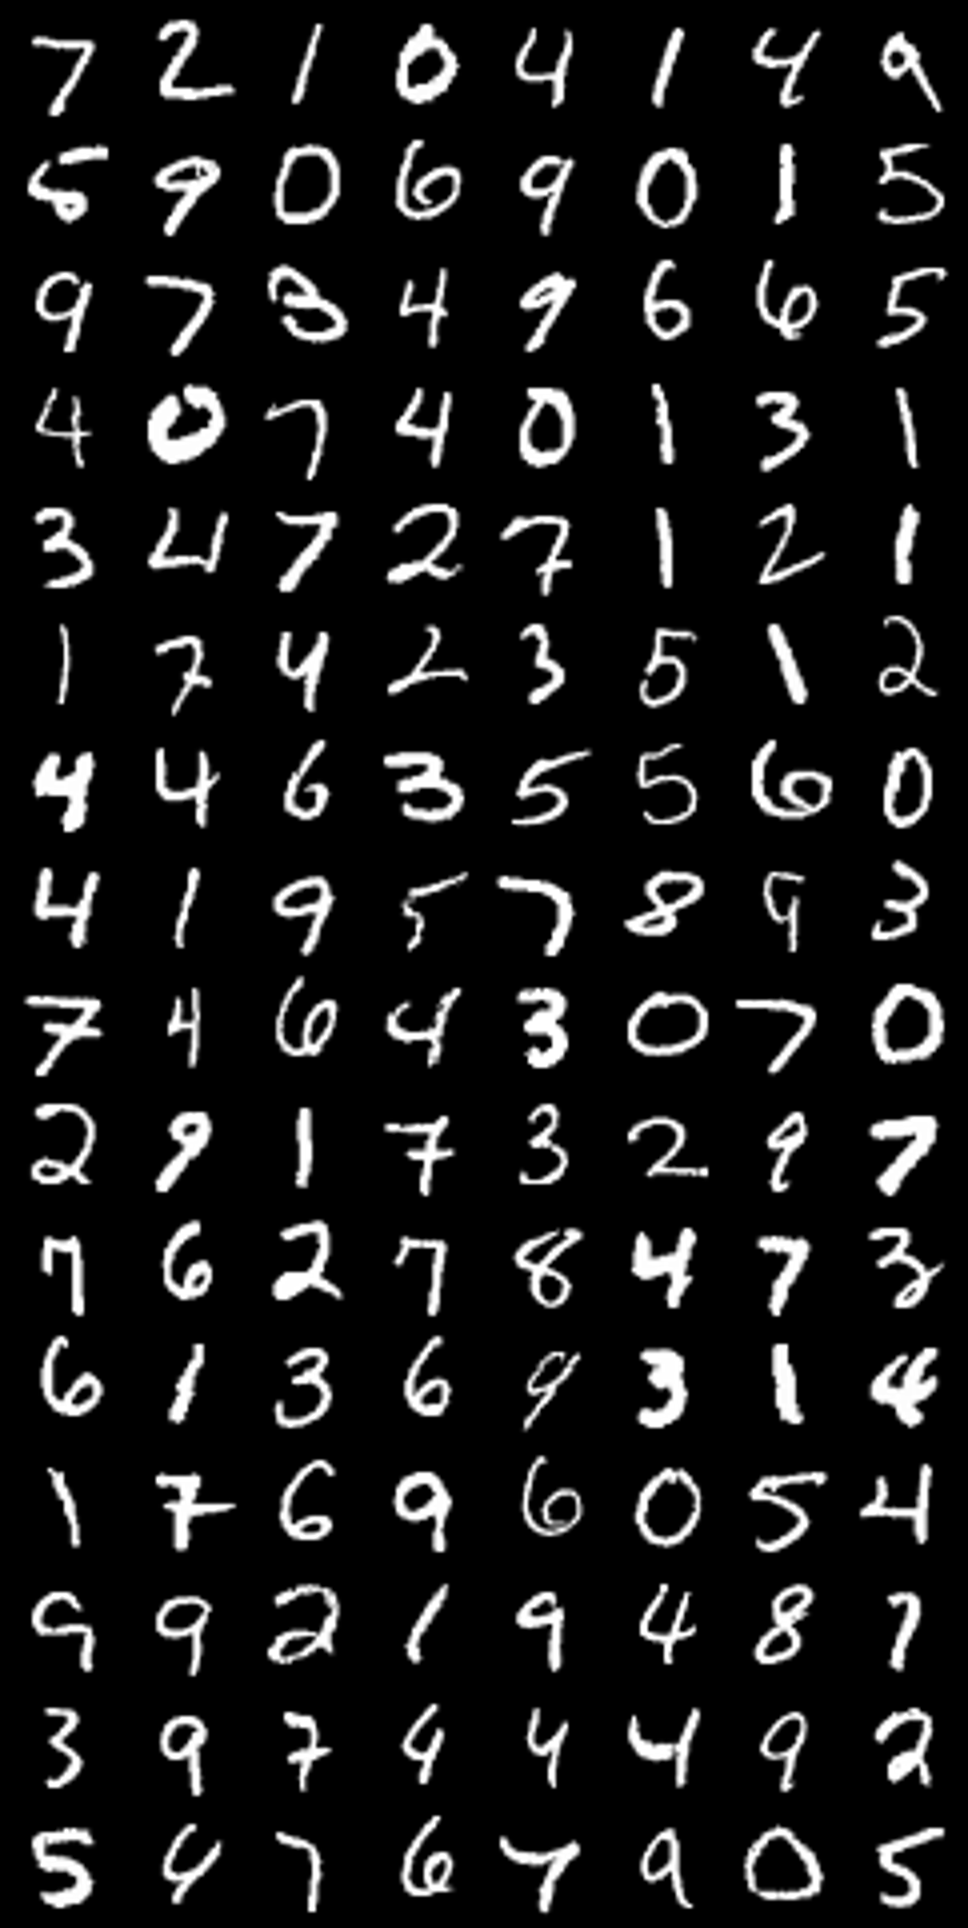

In [ ]:
visualize_grid(x)

In [ ]:
'''means, lbls = [], []
for data in testloader:
  x, labels = data
  x = x.to(device)

  with torch.no_grad():
    x_mean = model.encoder(x)[0]
  means.append(x_mean)
  lbls.append(labels)

features = torch.cat(means,0)
features = features.detach().cpu().numpy()
labels = torch.cat(lbls).numpy()

tsne = TSNE(n_components=2).fit_transform(features)'''

'means, lbls = [], []\nfor data in testloader:\n  x, labels = data\n  x = x.to(device)\n\n  with torch.no_grad():\n    x_mean = model.encoder(x)[0]\n  means.append(x_mean)\n  lbls.append(labels)\n\nfeatures = torch.cat(means,0)\nfeatures = features.detach().cpu().numpy()\nlabels = torch.cat(lbls).numpy()\n\ntsne = TSNE(n_components=2).fit_transform(features)'

In [ ]:
'''colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown"])
c = np.array([colors[el] for el in labels])
tsne_sel = tsne#[(labels==1)|(labels==4)]
col_sel = c#[(labels==3)|(labels==5)]
plt.scatter(tsne_sel[:,0], tsne_sel[:,1], c=col_sel)'''

'colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown"])\nc = np.array([colors[el] for el in labels])\ntsne_sel = tsne#[(labels==1)|(labels==4)]\ncol_sel = c#[(labels==3)|(labels==5)]\nplt.scatter(tsne_sel[:,0], tsne_sel[:,1], c=col_sel)'